In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import shapiro, zscore, ttest_ind
import numpy as np
from brokenaxes import brokenaxes
import datetime

In [2]:
# Function to create the dataframes per framework
# Also removed outliers
z_score_threshold = 2

def create_df (framework):
    dir = f"results/{framework}"
    csv_files = [f for f in os.listdir(dir) if f.endswith('.csv')]
    energy_values = []
    
    for file in csv_files:
        file_path = os.path.join(dir, file)
        df = pd.read_csv(file_path)
        
        if 'PACKAGE_ENERGY (J)' in df.columns:
            energy_diff = df['PACKAGE_ENERGY (J)'].iloc[-1] - df['PACKAGE_ENERGY (J)'].iloc[0]
            time_diff = df['Time'].iloc[-1] - df['Time'].iloc[0]
            
            energy_values.append({"PACKAGE ENERGY (J)": energy_diff, "EDP": time_diff })
        else:
            print(f"Skipping {file}, 'PACKAGE_ENERGY (J)' column not found.")
            
    energy_df = pd.DataFrame(energy_values)
    energy_df["Framework"] = framework.capitalize()
    z_scores = zscore(energy_df['PACKAGE ENERGY (J)'])
    energy_df, outlier_df  = energy_df[np.abs(z_scores) <= z_score_threshold], energy_df[np.abs(z_scores) > z_score_threshold]
    return energy_df, outlier_df

In [8]:
df_express, df_express_outlier = create_df("express")
df_flask, df_flask_outlier = create_df("flask")
df_spring, df_spring_outlier = create_df("springboot")
df = pd.concat([df_spring, df_express, df_flask])
df_outlier = pd.concat([df_spring_outlier, df_express_outlier, df_flask_outlier])
df_express_outlier.head(5)

,PACKAGE ENERGY (J),EDP,Framework
5,3113.414185,95159,Express
9,3114.813904,99775,Express


In [4]:
_, p_express = shapiro(df_express['PACKAGE ENERGY (J)'])
_, p_flask = shapiro(df_flask['PACKAGE ENERGY (J)'])
_, p_spring = shapiro(df_spring['PACKAGE ENERGY (J)'])
print(f"P-Value Express: {p_express}\nP-Value Flask: {p_flask}\nP-Value Springboot: {p_spring}")

P-Value Express: 0.36511326801069643
P-Value Flask: 0.18158651745589155
P-Value Springboot: 0.5862615714202133


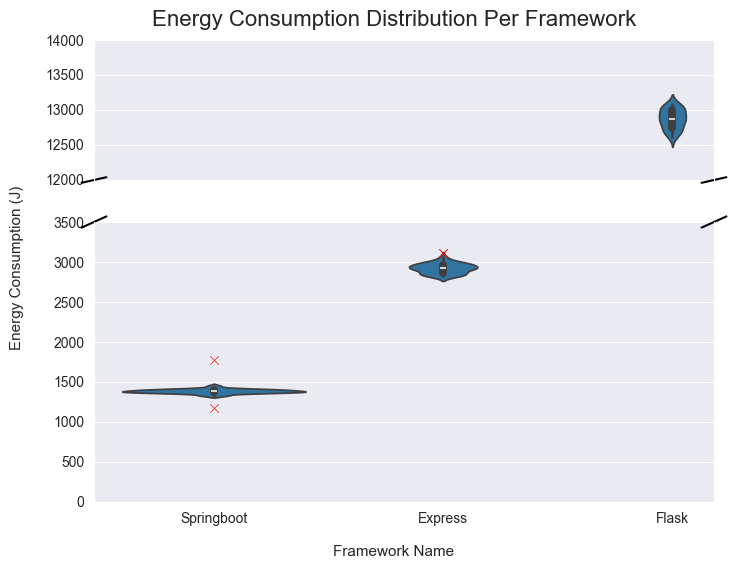

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,6), gridspec_kw={'height_ratios': [1,2]})

sns.violinplot(x="Framework", y="PACKAGE ENERGY (J)", data=df, ax=ax1)
sns.scatterplot(x="Framework", y="PACKAGE ENERGY (J)", data=df_outlier, ax=ax1, color='red', marker='x')
sns.violinplot(x="Framework", y="PACKAGE ENERGY (J)", data=df, ax=ax2)
sns.scatterplot(x="Framework", y="PACKAGE ENERGY (J)", data=df_outlier, ax=ax2, color='red', marker='x')


ax1.set_ylim(12000, 14000)
ax2.set_ylim(0, 3500)
ax1.set_ylabel('')
ax2.set_ylabel('')
ax2.set_xlabel('')

ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.set_visible(False)

d = 0.02  # Diagonal line size
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)  # Top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # Top-right diagonal

kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # Bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # Bottom-right diagonal

# Final plot
plt.suptitle("Energy Consumption Distribution Per Framework", y=0.93, fontsize=16)
fig.text(0.02, 0.5, 'Energy Consumption (J)', va="center", rotation="vertical", fontsize=11)
fig.text(0.5, 0.02, 'Framework Name', ha='center', fontsize=11)
# plt.ylabel("PACKAGE ENERGY (J)")
plt.show()


Text(0, 0.5, '')

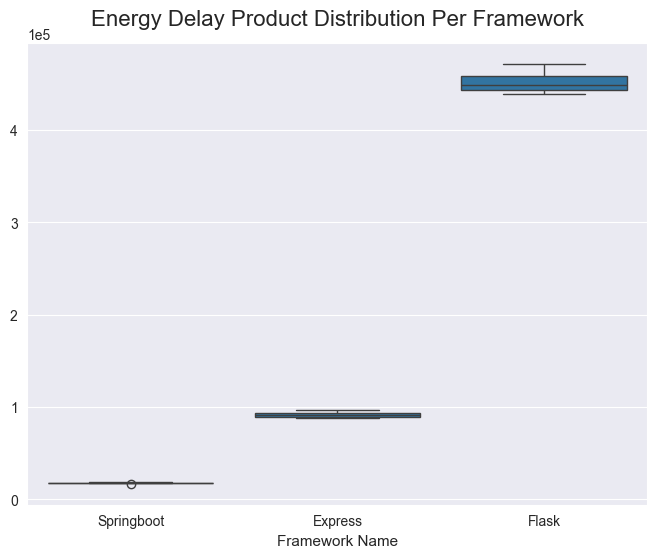

In [6]:
plt.figure(figsize=(8,6))
sns.boxplot(x='Framework', y='EDP', data=df)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.title('Energy Delay Product Distribution Per Framework', fontsize=16, y=1.02)
plt.xlabel('Framework Name', fontsize=11)
plt.ylabel('')

In [7]:
# Welch's t-test
for framework1 in ['Springboot', 'Express', 'Flask']:
    for framework2 in ['Springboot', 'Express', 'Flask']:
        if framework1 != framework2:
            sample_a = df[df['Framework'] == framework1]['PACKAGE ENERGY (J)']
            sample_b = df[df['Framework'] == framework2]['PACKAGE ENERGY (J)']
            _,pvalue = ttest_ind(sample_a, sample_b,
                                 equal_var=False,
                                 alternative='two-sided')
            print(f"Comparing {framework1} and {framework2} p-value: {pvalue}")
            print(f"Mean difference: {sample_a.mean() - sample_b.mean()}")
            print(f"Percent change w.r.t to {framework2}: {(sample_a.mean() - sample_b.mean() )/ sample_b.mean()}")
            print(" ")


Comparing Springboot and Express p-value: 6.6572345500116616e-49
Mean difference: -1536.7445155552448
Percent change w.r.t to Express: -0.5258957747005653
 
Comparing Springboot and Flask p-value: 2.4302185901807646e-56
Mean difference: -11488.460172380715
Percent change w.r.t to Flask: -0.8923864495078961
 
Comparing Express and Springboot p-value: 6.6572345500116616e-49
Mean difference: 1536.7445155552448
Percent change w.r.t to Springboot: 1.1092408517735102
 
Comparing Express and Flask p-value: 1.51183344019213e-66
Mean difference: -9951.715656825472
Percent change w.r.t to Flask: -0.7730171030976635
 
Comparing Flask and Springboot p-value: 2.4302185901807646e-56
Mean difference: 11488.460172380715
Percent change w.r.t to Springboot: 8.292510054980257
 
Comparing Flask and Express p-value: 1.51183344019213e-66
Mean difference: 9951.715656825472
Percent change w.r.t to Express: 3.4056182807036235
 
